# Install and import related modules

You will need the following version of the packages in order to exactly replicate the workflow in this notebook
1. `opencv-contrib-python==4.6.0.66` (required)
2. `matplotlib==3.3.1` (optional)

In [2]:
# !pip install opencv-contrib-python==4.6.0.66

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [4]:
cv2.__version__

'4.6.0'

# Read images

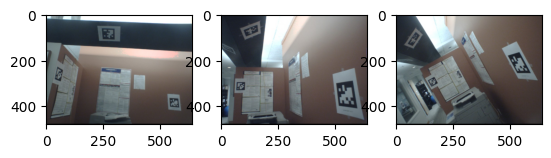

In [5]:
img1 = cv2.imread('00003.jpg')
img2 = cv2.imread('00006.jpg')
img3 = cv2.imread('00007.jpg')
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img1[:, :, ::-1])
axes[1].imshow(img2[:, :, ::-1])
axes[2].imshow(img3[:, :, ::-1])

#Input the pre-calibrated intrinsic parameters

In [6]:
fx = 520.544057821402
fy = 520.1849733954289
cx = 291.4731915436965
cy = 239.5481569250349
k1 = -0.09121325191796478
k2 = 0.1657800009678882
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
distCoeffs = np.array([k1, k2, 0, 0])

# Detect AprilTag corners

id1: [8 5 4]
id2: [5 8 7]
id3: [5 8 7]


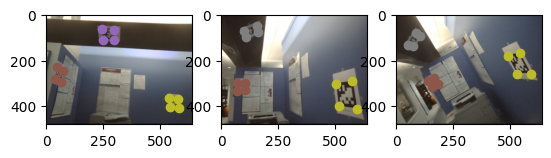

In [7]:
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_APRILTAG_36h11)
arucoParams = cv2.aruco.DetectorParameters_create()
arucoParams.adaptiveThreshConstant = 5
impts1, ids1, _ = cv2.aruco.detectMarkers(img1, arucoDict, parameters=arucoParams)
impts2, ids2, _ = cv2.aruco.detectMarkers(img2, arucoDict, parameters=arucoParams)
impts3, ids3, _ = cv2.aruco.detectMarkers(img3, arucoDict, parameters=arucoParams)

ids1 = ids1.ravel()
ids2 = ids2.ravel()
ids3 = ids3.ravel()

print("id1:", ids1)
print("id2:", ids2)
print("id3:", ids3)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img1, cmap='gray')
axes[1].imshow(img2, cmap='gray')
axes[2].imshow(img3, cmap='gray')

for idx, pts in zip(ids1, impts1):
    axes[0].scatter(pts[0, :, 0], pts[0, :, 1], color='C%d' % idx)

for idx, pts in zip(ids2, impts2):
    axes[1].scatter(pts[0, :, 0], pts[0, :, 1], color='C%d' % idx)

for idx, pts in zip(ids3, impts3):
    axes[2].scatter(pts[0, :, 0], pts[0, :, 1], color='C%d' % idx)

# Inital pose estimation for img1 and img2

## Estimate essential matrix

**Question in Class:** 

1. How can we estimate $E$? 
2. How many pair of points do we need for estimating $E$? 
3. Why do we want to estimate $E$ here? What is it used for?

In [8]:
x1 = np.concatenate((impts1[1][0], impts1[0][0]))
x2 = np.concatenate((impts2[0][0], impts2[1][0]))
E, mask = cv2.findEssentialMat(x1, x2, K)

In [9]:
E

array([[ 0.03491743,  0.33430139, -0.13569921],
       [ 0.47081614, -0.00484347, -0.50912495],
       [-0.13091537,  0.60768678, -0.03588191]])

## Decompose essential matrix

**Question in Class:** 

1. Why do we want to decompose $E$? What can it be used for?
2. Why are there 4 values?
3. Why do we need triangulation here?

In [10]:
RR1, RR2, t = cv2.decomposeEssentialMat(E)
projMatLeft = K @ np.concatenate((np.eye(3), np.zeros((3, 1))), axis=1) #instantiate as origin
projMatRight1 = K @ np.concatenate((RR1, t), axis=1) #candidate configurations
projMatRight2 = K @ np.concatenate((RR1, -t), axis=1) #candidate configurations
projMatRight3 = K @ np.concatenate((RR2, t), axis=1) #candidate configurations
projMatRight4 = K @ np.concatenate((RR2, -t), axis=1) #candidate configurations

In [88]:
projMatLeft

array([[520.54405782,   0.        , 291.47319154,   0.        ],
       [  0.        , 520.1849734 , 239.54815693,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [89]:
projMatRight1

array([[ 5.75215555e+02, -3.80856649e+00, -1.58225466e+02,
         3.08817420e+02],
       [ 5.46093200e+01, -5.21537857e+02, -2.30199505e+02,
        -2.15192307e+02],
       [ 2.39629569e-01, -5.70140752e-03, -9.70847652e-01,
        -4.73899642e-01]])

In [90]:
projMatRight1.round(5)

array([[ 5.7521555e+02, -3.8085700e+00, -1.5822547e+02,  3.0881742e+02],
       [ 5.4609320e+01, -5.2153786e+02, -2.3019951e+02, -2.1519231e+02],
       [ 2.3963000e-01, -5.7000000e-03, -9.7085000e-01, -4.7390000e-01]])

## Triangulate points

In [11]:
#Triangulate
X1 = cv2.triangulatePoints(projMatLeft, projMatRight1, x1.T, x2.T)
X2 = cv2.triangulatePoints(projMatLeft, projMatRight2, x1.T, x2.T)
X3 = cv2.triangulatePoints(projMatLeft, projMatRight3, x1.T, x2.T)
X4 = cv2.triangulatePoints(projMatLeft, projMatRight4, x1.T, x2.T)

#Normalize
X1 = X1 / X1[-1]
X2 = X2 / X2[-1]
X3 = X3 / X3[-1]
X4 = X4 / X4[-1]

#Check whether the points are infront of the camera | Cheirality Condition check
print('z1:', X1[2])
print('z2:', X2[2])
print('z3:', X3[2])
print('z4:', X4[2])

z1: [ 1.2014402   0.935267    0.97483623  1.2530469  -0.8921536  -0.98327106
 -0.99742436 -0.90567255]
z2: [-1.2014402  -0.935267   -0.97483623 -1.2530469   0.8921536   0.98327106
  0.99742436  0.90567255]
z3: [-0.6361104  -0.57847923 -0.5956421  -0.6537709  -0.8756531  -0.87847525
 -0.8982554  -0.8935583 ]
z4: [0.6361104  0.57847923 0.5956421  0.6537709  0.8756531  0.87847525
 0.8982554  0.8935583 ]


In [12]:
X4.shape #why is this of this shape?

(4, 8)

Values in `z4` are all positive. Therefore, we choose $(-RR_2, -t)$ as the intial pose for `img2`, and `X4` as the intial position for the object points.

# Initial pose estimation for img3

Let's do the same and figure out the position of `Camera 3` directly via cv2's `solvePnP` to save time.

In [13]:
x3 = np.array(impts3[:2]).reshape(8,2) #why this specific configuration?
X4 = X4.T
ret, rvec, tvec = cv2.solvePnP(X4[:, :3], x3, K, distCoeffs) #why X4[:,:3]?

# Bundle Adjustment
Now, let's perform bundle adjustment to tigthen up our estimates to reconstruct the 3D points.

## Create inital parameter vector

In [14]:
# params0 = [rvec1, rvec2, rvec3, tvec1, tvec2, tvec3, X1, X2, X3, X4, X5, X6, X7, X8]
rvec1 = cv2.Rodrigues(np.eye(3))[0][:, 0] #3
rvec2 = cv2.Rodrigues(RR2)[0][:, 0]  #3
rvec3 = rvec[:, 0] #3


tvec1 = np.zeros(3) #3
tvec2 = -t[:, 0] #3
tvec3 = tvec[:, 0] #3

X_0 = X4[:, :3].ravel() #24


params0 = np.concatenate([rvec1, rvec2, rvec3, tvec1, tvec2, tvec3, X_0]) 

## Create visibility matrix and observations

Visibility matrix signifies the relationship between the camera and a point. $V_{ij}$ is one if $j$ th point is visible from the $i$ th camera and zero otherwise.

We'll need this for the Bundle Adjustment step

In [15]:
#Create visibility matrix
visibility = [[True]*8]*3 #why these numbers?
visibility = np.array(visibility, dtype=bool)

#Create corresponding observation pixel coord
x_obs = np.concatenate([x1, x2, x3]) # Nx24

print(visibility)

[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]]


## Create objective function

**Question in Class**: What is the loss function we use for Bundle Adjustment?

(-4.0, 4.0)

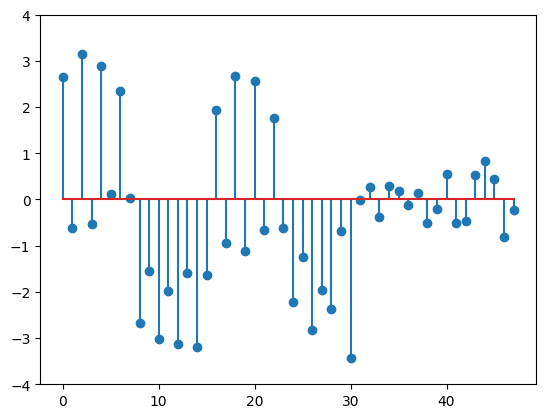

In [16]:
#The loss function
def fun(params, K, distCoeffs, n_cams, visibility, x_obs):
    rvecs = params[:3*n_cams]
    tvecs = params[3*n_cams:6*n_cams]
    X = params[6*n_cams:] 
    x_hat = []
    for i in range(n_cams):
        rvec, tvec = rvecs[i*3:i*3+3], tvecs[i*3:i*3+3]
        mask = visibility[i]
        x = cv2.projectPoints(X.reshape(-1, 3), rvec, tvec, K, distCoeffs)[0][mask, 0, :] #N_ix2
        x_hat.append(x)
    x_hat = np.concatenate(x_hat) 
    return (x_hat - x_obs).ravel()    

#Compute and plot our loss
plt.stem(fun(params0, K, distCoeffs, 3, visibility, x_obs))
plt.ylim([-4, 4])

## Optimization

Now the above is not that great without optimization, let's try to optimize it via Least Squares - this is known as **Bundle Adjustment**

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1095e+01                                    1.39e+04    
       1              4         3.8511e+01      3.26e+01       2.97e-01       2.41e+04    
       2              6         1.7391e+00      3.68e+01       4.22e-02       2.44e+03    
       3              8         1.4283e+00      3.11e-01       2.84e-02       2.19e+02    
       4             10         1.4179e+00      1.03e-02       1.22e-02       9.63e+01    
       5             12         1.4175e+00      4.13e-04       7.35e-03       4.32e+01    
       6             14         1.4174e+00      1.25e-04       3.63e-03       1.30e+01    
`ftol` termination condition is satisfied.
Function evaluations 14, initial cost 7.1095e+01, final cost 1.4174e+00, first-order optimality 1.30e+01.


(-4.0, 4.0)

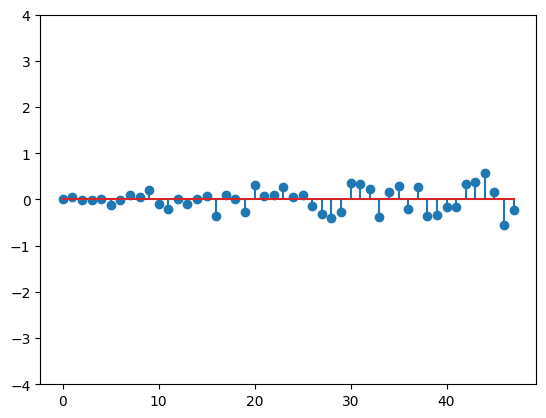

In [17]:
#Optimize and extract
res = least_squares(fun, params0, verbose=2, x_scale='jac', ftol=1e-4, method='trf', args=(K, distCoeffs, 3, visibility, x_obs))
rvec1_o, rvec2_o, rvec3_o = res.x[:3], res.x[3:6], res.x[6:9]
tvec1_o, tvec2_o, tvec3_o = res.x[9:12], res.x[12:15], res.x[15:18]
X_o = res.x[18:].reshape(-1, 3)

#Plot our loss
plt.stem(res.fun)
plt.ylim([-4, 4])

Much better!

# Visualization

[0.05060714 0.05147994 0.05153565]


Text(0.5, 0, 'Z')

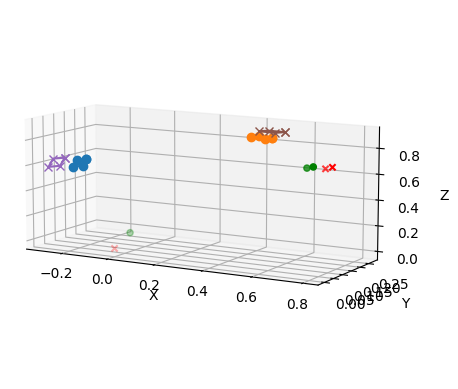

In [18]:
#Compute the corresponding transformation from our adjustment step
R1_o, R2_o, R3_o = cv2.Rodrigues(rvec1_o[:, None])[0], cv2.Rodrigues(rvec2_o[:, None])[0], cv2.Rodrigues(rvec3_o[:, None])[0]
p1, p2, p3 = -R1_o.T @ tvec1_o, -R2_o.T @ tvec2_o, -R3_o.T @ tvec3_o


#Plot
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.set_box_aspect((np.ptp(X_o[:, 0]), np.ptp(X_o[:, 1]), np.ptp(X_o[:, 2])))

# plot optimized camera pose and markers
ax.plot(X_o[[0, 1, 2, 3, 0], 0], X_o[[0, 1, 2, 3, 0], 1], X_o[[0, 1, 2, 3, 0], 2], marker='o', color='C0')
ax.plot(X_o[[4, 5, 6, 7, 4], 0], X_o[[4, 5, 6, 7, 4], 1], X_o[[4, 5, 6, 7, 4], 2], marker='o', color='C1')
ax.scatter([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], [p1[2], p2[2], p3[2]], marker='o', color='g')


# plot inital camera pose and markers
R1_0, R2_0, R3_0 = cv2.Rodrigues(rvec1[:, None])[0], cv2.Rodrigues(rvec2[:, None])[0], cv2.Rodrigues(rvec3[:, None])[0]
p1_0, p2_0, p3_0 = -R1_0.T @ tvec1, -R2_0.T @ tvec2, -R3_0.T @ tvec3


X_0 = X_0.reshape(-1, 3)
ax.plot(X_0[[0, 1, 2, 3, 0], 0], X_0[[0, 1, 2, 3, 0], 1], X_0[[0, 1, 2, 3, 0], 2], marker='x', color='C4')
ax.plot(X_0[[4, 5, 6, 7, 4], 0], X_0[[4, 5, 6, 7, 4], 1], X_0[[4, 5, 6, 7, 4], 2], marker='x', color='C5')
ax.scatter([p1_0[0], p2_0[0], p3_0[0]], [p1_0[1], p2_0[1], p3_0[1]], [p1_0[2], p2_0[2], p3_0[2]], marker='x', color='r')

ax.azim = -60
ax.elev = 10
print(np.linalg.norm(X_o[1:4] - X_o[0:3], axis=-1))


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Homework

Triangulate the top-right corner of the right poster using the optimized camera pose:

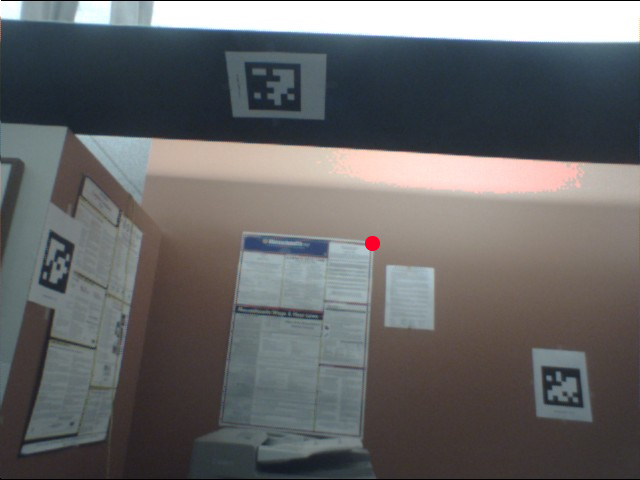


## Measure image cooridnates

Hint: You may use Windows Paint to measure the image cooridnates.

In [126]:
# Hint: Image coordinates should be stored in an 1x2 numpy array:
x_left  = np.array([372., 246.]) # 00003.JPG
x_right = np.array([343., 164.]) # 00006.JPG
#         np.array([303, 76])  # 00007.JPG

## Create projection matrix

In [99]:
# Hint: P = K @ np.concatenate((R, t), axis=1). 
# You need to use the optimized R and t (R1_o, R2_o, R3_o, tvec1_o, tvec2_o, tvec3_o) after the bundle adjustment
# P_left = K @ np.concatenate((R_o, t_o), axis=1)
P_left  = K @ np.concatenate((R1_o, np.transpose([tvec1_o])), axis=1)
P_right = K @ np.concatenate((R2_o, np.transpose([tvec2_o])), axis=1)
#       = K @ np.concatenate((R3_o, np.transpose([tvec3_o])), axis=1)

## Triangulate point

In [129]:
# Hint: Use cv2.triangulatePoints(). Pay attnention to the I/O array dimensions. Normalize the final homogenous coordinates.
# reference https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gad3fc9a0c82b08df034234979960b778c
X_corner = cv2.triangulatePoints(P_left, P_right, np.transpose([x_left.T]), np.transpose([x_right.T]))
X_corner = X_corner / X_corner[-1]
# print(X_corner[2])

[[0.13170643]
 [0.01645028]
 [0.67058466]
 [0.72986233]]

[[0.18045379]
 [0.02253888]
 [0.91878241]
 [1.        ]]



[0.05060714 0.05147994 0.05153565]


Text(0.5, 0, 'Z')

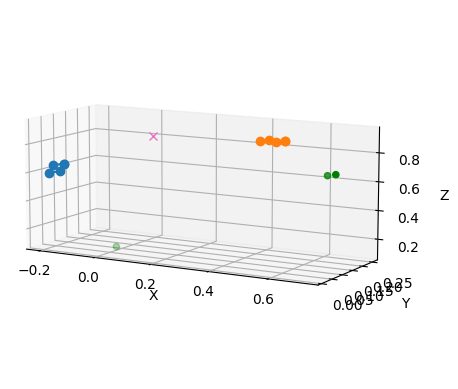

In [155]:
#Plot
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.set_box_aspect((np.ptp(X_o[:, 0]), np.ptp(X_o[:, 1]), np.ptp(X_o[:, 2])))

# plot optimized camera pose and markers
ax.plot(X_o[[0, 1, 2, 3, 0], 0], X_o[[0, 1, 2, 3, 0], 1], X_o[[0, 1, 2, 3, 0], 2], marker='o', color='C0')
ax.plot(X_o[[4, 5, 6, 7, 4], 0], X_o[[4, 5, 6, 7, 4], 1], X_o[[4, 5, 6, 7, 4], 2], marker='o', color='C1')
ax.scatter([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], [p1[2], p2[2], p3[2]], marker='o', color='g')


# plot inital camera pose and markers
R1_0, R2_0, R3_0 = cv2.Rodrigues(rvec1[:, None])[0], cv2.Rodrigues(rvec2[:, None])[0], cv2.Rodrigues(rvec3[:, None])[0]
p1_0, p2_0, p3_0 = -R1_0.T @ tvec1, -R2_0.T @ tvec2, -R3_0.T @ tvec3


X_0 = X_0.reshape(-1, 3)
# ax.plot(X_0[[0, 1, 2, 3, 0], 0], X_0[[0, 1, 2, 3, 0], 1], X_0[[0, 1, 2, 3, 0], 2], marker='x', color='C4')
# ax.plot(X_0[[4, 5, 6, 7, 4], 0], X_0[[4, 5, 6, 7, 4], 1], X_0[[4, 5, 6, 7, 4], 2], marker='x', color='C5')
# ax.scatter([p1_0[0], p2_0[0], p3_0[0]], [p1_0[1], p2_0[1], p3_0[1]], [p1_0[2], p2_0[2], p3_0[2]], marker='x', color='r')

ax.plot(0.18045379, 0.02253888, 0.91878241, marker='x', color='C6')
# ax.plot(0.18, 0.02, 0.92, marker='x', color='C7')

ax.azim = -60
ax.elev = 10
print(np.linalg.norm(X_o[1:4] - X_o[0:3], axis=-1))


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')